# < 16. Movielens 영화 SBR >
- `Movielens 1M Dataset`을 기반으로, `Session based Recommendation` 시스템을 제작하기

## [루브릭]
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.

## [Session based Recommendation]
- 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천
- 같은 유저라도 서로 다른 세션 활동을 가지므로, 이를 독립적으로 보고 유저가 아닌 세션 이벤트 기준으로 모델링
- <mark>Session</mark> : 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장된다

---

## Step1. 데이터 로드

In [1]:
import pandas
import tensorflow

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- UserID가 SessionID 역할
- Rating 정보 처리
- Time은 UTC time이 포함되어, 1970년 1월1일부터 경과된 초 단위 시간이 기재

---

## Step2. 데이터 전처리

#### 2-1 데이터 정보 확인

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


#### 2-2 시간을 표준시로 변환

In [4]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


#### 2-3 유저 수, 영화 수, 시간 수

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

> 유저 수 : 6040 <br>
> 영화 수 : 3706 

#### 2-4 SessionID 추가

In [6]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df.head(20)

,index,UserId,Time,ItemId
0,0,1,2000-12-31 22:00:19,1
1,1,1,2000-12-31 22:00:55,3
2,2,1,2000-12-31 22:01:43,1
3,3,1,2000-12-31 22:02:52,1
4,4,1,2000-12-31 22:04:35,1
5,5,1,2000-12-31 22:11:59,2
6,6,1,2000-12-31 22:12:40,3
7,7,1,2000-12-31 22:22:48,1
8,8,1,2000-12-31 22:23:18,1
9,9,1,2000-12-31 22:26:10,1


In [7]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data.head()

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,2000-12-31 22:00:19,0,1
1,1,1270,5,2000-12-31 22:00:55,1,3
2,1,1721,4,2000-12-31 22:00:55,1,3
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,1


In [8]:
data.drop(columns='ItemId_y', inplace=True)
data.head()

,UserId,ItemId_x,Rating,Time,index
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2


In [9]:
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data.head()

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2


#### 2-5 평점 3점 이상만 남기기

In [10]:
data = data[data['Rating'] >= 3]
data.head(10)

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
5,1,1836,5,2000-12-31 22:02:52,3
6,1,3408,4,2000-12-31 22:04:35,4
7,1,2804,5,2000-12-31 22:11:59,5
8,1,1207,4,2000-12-31 22:11:59,5
9,1,1193,5,2000-12-31 22:12:40,6


### Session Length

In [11]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 423408, dtype: int64

In [12]:
session_length.median(), session_length.mean()

(1.0, 1.9755838340324225)

In [13]:
session_length.min(), session_length.max()

(1, 28)

In [14]:
session_length.quantile(0.999)

10.0

> 각 세션의 길이는 보통 1~2 <br>
99.9% 세션은 길이가 10이하 <br>
길이가 28인 세션 확인 필요

#### 세션 길이 기준 하위 99.9%까지의 분포 누적합

In [15]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.514338
2    0.751370
3    0.876445
4    0.938879
5    0.970388
6    0.986186
7    0.993720
8    0.997112
9    0.998682
dtype: float64

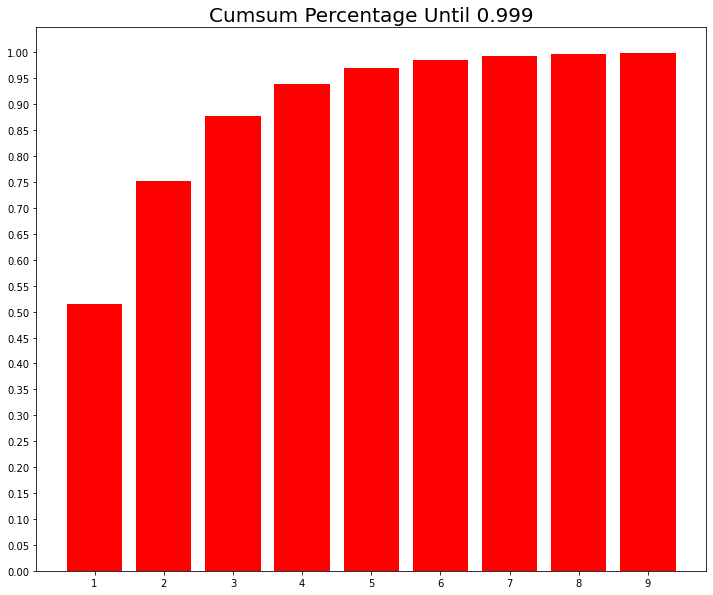

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### 길이가 28인 세션 확인

In [17]:
long_session = session_length[session_length==28].index[0]
long_session

55112

In [18]:
data[data['SessionId'] == long_session]

,UserId,ItemId,Rating,Time,SessionId
112250,731,2054,4,2000-11-29 19:56:21,55112
112251,731,2,5,2000-11-29 19:56:21,55112
112252,731,2087,5,2000-11-29 19:56:21,55112
112253,731,788,4,2000-11-29 19:56:21,55112
112254,731,1654,5,2000-11-29 19:56:21,55112
112255,731,247,4,2000-11-29 19:56:21,55112
112256,731,260,3,2000-11-29 19:56:21,55112
112257,731,2100,5,2000-11-29 19:56:21,55112
112258,731,2105,4,2000-11-29 19:56:21,55112
112259,731,653,4,2000-11-29 19:56:21,55112


In [19]:
data[data['SessionId'] == long_session].shape

(28, 5)

In [20]:
# 1초에 28개의 영화를 평가했다
# 이상치로 보고 제거

idx = data[data['SessionId'] == 55112].index
data = data.drop(idx)

In [22]:
data[data['SessionId'] == long_session]

,UserId,ItemId,Rating,Time,SessionId


### Session Time

In [23]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


> 3년치의 데이터가 있다

### Data Cleansing
- 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이 목적이므로 길이가 1인 세션은 제거
- 너무 적게 클릭된 아이템 또한 제거

In [24]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()       # 세션 아이디로 묶고
    session_use = session_len[session_len >= shortest].index  # 최소길이보다 긴 세션만 남기고
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [25]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,SessionId
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
7,1,2804,5,2000-12-31 22:11:59,5
8,1,1207,4,2000-12-31 22:11:59,5
...,...,...,...,...,...
1000189,6040,3362,4,2001-08-10 14:29:56,471145
1000190,6040,3421,3,2001-08-10 14:31:49,471146
1000191,6040,1258,4,2001-08-10 14:31:49,471146
1000205,6040,1921,4,2001-08-10 14:41:04,471160


### Train / Valid / Test split

In [26]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [27]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

In [28]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [29]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 615215
	 Sessions: 204396
	 Items: 3168
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2002-10-29 19:11:50

* valid Set Stats Info
	 Events: 1122
	 Sessions: 446
	 Items: 773
	 First Time : 2002-10-31 14:40:43
	 Last Time : 2002-12-30 01:20:28

* test Set Stats Info
	 Events: 1227
	 Sessions: 479
	 Items: 818
	 First Time : 2002-12-30 19:40:25
	 Last Time : 2003-02-28 17:49:08



In [30]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [31]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

---

## Step3. Data Pipeline

### SesionDataset

In [32]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [33]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,2000-12-31 22:00:55,1,0
2,1,1721,4,2000-12-31 22:00:55,1,1
3,1,1022,5,2000-12-31 22:00:55,1,2
7,1,2804,5,2000-12-31 22:11:59,5,3
8,1,1207,4,2000-12-31 22:11:59,5,4
9,1,1193,5,2000-12-31 22:12:40,6,5
10,1,720,3,2000-12-31 22:12:40,6,6
11,1,260,4,2000-12-31 22:12:40,6,7
19,1,1035,5,2000-12-31 22:29:13,14,8
20,1,1962,4,2000-12-31 22:29:13,14,9


In [34]:
tr_dataset.click_offsets

array([     0,      3,      5, ..., 615211, 615213, 615215], dtype=int32)

In [35]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 204393, 204394, 204395])

### SessionDataLoader
`SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
`__iter__` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`합니다.
mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [36]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [37]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,2000-12-31 22:00:55,1,0
2,1,1721,4,2000-12-31 22:00:55,1,1
3,1,1022,5,2000-12-31 22:00:55,1,2
7,1,2804,5,2000-12-31 22:11:59,5,3
8,1,1207,4,2000-12-31 22:11:59,5,4
9,1,1193,5,2000-12-31 22:12:40,6,5
10,1,720,3,2000-12-31 22:12:40,6,6
11,1,260,4,2000-12-31 22:12:40,6,7
19,1,1035,5,2000-12-31 22:29:13,14,8
20,1,1962,4,2000-12-31 22:29:13,14,9


In [38]:
iter_ex = iter(tr_data_loader)

In [39]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 8]
Label Item Idx are :       [1 4 6 9]
Previous Masked Input Idx are []


---

## Step4. Modeling

### Evaluation Metric
모델 성능 평가를 위한 지표를 보겠습니다.
모델 성능에 대한 지표로 `precision`이나 `recall`이 있습니다.
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
이 때문에 recall의 개념을 확장한 `recall@k` 지표, precision의 개념을 확장한 `Mean Average Precision@k` 지표 등을 사용합니다.
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.
따라서 순서에 민감한 지표인 `MRR`, `NDCG` 같은 지표도 사용합니다.
이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.

In [40]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [42]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [43]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

### 모델 설계

In [44]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3168)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    483000    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3168)               161568    
Total params: 644,568
Trainable params: 644,568
Non-trainable params: 0
_________________________________________________________________


---

## Step5. Model Training

In [45]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [46]:
train_model(model, args)

Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.64it/s]


	 - Recall@20 epoch 1: 0.080078
	 - MRR@20    epoch 1: 0.020505



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.86it/s]


	 - Recall@20 epoch 2: 0.144531
	 - MRR@20    epoch 2: 0.045781



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.88it/s]


	 - Recall@20 epoch 3: 0.177734
	 - MRR@20    epoch 3: 0.055511



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]


	 - Recall@20 epoch 4: 0.187500
	 - MRR@20    epoch 4: 0.055112



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.93it/s]


	 - Recall@20 epoch 5: 0.191406
	 - MRR@20    epoch 5: 0.053402



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.97it/s]


	 - Recall@20 epoch 6: 0.201172
	 - MRR@20    epoch 6: 0.054338



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]


	 - Recall@20 epoch 7: 0.203125
	 - MRR@20    epoch 7: 0.053645



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]


	 - Recall@20 epoch 8: 0.203125
	 - MRR@20    epoch 8: 0.052744



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.98it/s]


	 - Recall@20 epoch 9: 0.203125
	 - MRR@20    epoch 9: 0.053165



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.92it/s]

	 - Recall@20 epoch 10: 0.199219
	 - MRR@20    epoch 10: 0.052729



---

## Step6. Model Test

In [47]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [48]:
test_model(model, args, test)

Evaluation: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

	 - Recall@20: 0.235937
	 - MRR@20: 0.095445



---

## Step7. 다양한 시도

### 1. 에폭 증가(10 -> 20)

In [49]:
args1 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3168)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    483000    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3168)               161568    
Total params: 644,568
Trainable params: 644,568
Non-trainable params: 0
_________________________________________________________________


In [50]:
train_model(model1, args1)

Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.65it/s]


	 - Recall@20 epoch 1: 0.083984
	 - MRR@20    epoch 1: 0.020540



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.83it/s]


	 - Recall@20 epoch 2: 0.158203
	 - MRR@20    epoch 2: 0.041010



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]


	 - Recall@20 epoch 3: 0.197266
	 - MRR@20    epoch 3: 0.050312



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.92it/s]


	 - Recall@20 epoch 4: 0.201172
	 - MRR@20    epoch 4: 0.056657



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]


	 - Recall@20 epoch 5: 0.216797
	 - MRR@20    epoch 5: 0.058239



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.94it/s]


	 - Recall@20 epoch 6: 0.208984
	 - MRR@20    epoch 6: 0.057318



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.92it/s]


	 - Recall@20 epoch 7: 0.201172
	 - MRR@20    epoch 7: 0.055503



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]


	 - Recall@20 epoch 8: 0.201172
	 - MRR@20    epoch 8: 0.052891



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]


	 - Recall@20 epoch 9: 0.197266
	 - MRR@20    epoch 9: 0.051342



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.93it/s]


	 - Recall@20 epoch 10: 0.201172
	 - MRR@20    epoch 10: 0.053394



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]


	 - Recall@20 epoch 11: 0.199219
	 - MRR@20    epoch 11: 0.052403



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.90it/s]


	 - Recall@20 epoch 12: 0.197266
	 - MRR@20    epoch 12: 0.051693



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.94it/s]


	 - Recall@20 epoch 13: 0.195312
	 - MRR@20    epoch 13: 0.051211



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.94it/s]


	 - Recall@20 epoch 14: 0.195312
	 - MRR@20    epoch 14: 0.049344



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.92it/s]


	 - Recall@20 epoch 15: 0.195312
	 - MRR@20    epoch 15: 0.048718



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]


	 - Recall@20 epoch 16: 0.197266
	 - MRR@20    epoch 16: 0.047326



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.88it/s]


	 - Recall@20 epoch 17: 0.189453
	 - MRR@20    epoch 17: 0.045294



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.85it/s]


	 - Recall@20 epoch 18: 0.187500
	 - MRR@20    epoch 18: 0.046290



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.93it/s]


	 - Recall@20 epoch 19: 0.189453
	 - MRR@20    epoch 19: 0.046207



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.92it/s]

	 - Recall@20 epoch 20: 0.187500
	 - MRR@20    epoch 20: 0.046003



In [51]:
test_model(model1, args1, test)

Evaluation: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

	 - Recall@20: 0.231250
	 - MRR@20: 0.092615



### 2. 배치사이즈 증가(128 -> 256)

In [54]:
args2 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model2 = create_model(args2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3168)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    483000    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3168)               161568    
Total params: 644,568
Trainable params: 644,568
Non-trainable params: 0
_________________________________________________________________


In [55]:
train_model(model2, args2)

Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


	 - Recall@20 epoch 1: 0.033203
	 - MRR@20    epoch 1: 0.004372



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


	 - Recall@20 epoch 2: 0.091797
	 - MRR@20    epoch 2: 0.017791



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


	 - Recall@20 epoch 3: 0.123047
	 - MRR@20    epoch 3: 0.027232



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


	 - Recall@20 epoch 4: 0.128906
	 - MRR@20    epoch 4: 0.033711



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


	 - Recall@20 epoch 5: 0.138672
	 - MRR@20    epoch 5: 0.032166



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


	 - Recall@20 epoch 6: 0.144531
	 - MRR@20    epoch 6: 0.032825



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


	 - Recall@20 epoch 7: 0.148438
	 - MRR@20    epoch 7: 0.034604



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


	 - Recall@20 epoch 8: 0.150391
	 - MRR@20    epoch 8: 0.035155



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


	 - Recall@20 epoch 9: 0.146484
	 - MRR@20    epoch 9: 0.035480



Evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

	 - Recall@20 epoch 10: 0.148438
	 - MRR@20    epoch 10: 0.036371



In [56]:
test_model(model2, args2, test)

Evaluation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

	 - Recall@20: 0.238281
	 - MRR@20: 0.083482



### 3. 배치사이즈 감소(128 -> 64)

In [57]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model3 = create_model(args3)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3168)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      483000    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 3168)                161568    
Total params: 644,568
Trainable params: 644,568
Non-trainable params: 0
_________________________________________________________________


In [58]:
train_model(model3, args3)

Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.28it/s]


	 - Recall@20 epoch 1: 0.131944
	 - MRR@20    epoch 1: 0.032738



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.65it/s]


	 - Recall@20 epoch 2: 0.185764
	 - MRR@20    epoch 2: 0.058842



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]


	 - Recall@20 epoch 3: 0.210069
	 - MRR@20    epoch 3: 0.064403



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.66it/s]


	 - Recall@20 epoch 4: 0.210069
	 - MRR@20    epoch 4: 0.063613



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.68it/s]


	 - Recall@20 epoch 5: 0.217014
	 - MRR@20    epoch 5: 0.065524



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.55it/s]


	 - Recall@20 epoch 6: 0.208333
	 - MRR@20    epoch 6: 0.062092



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]


	 - Recall@20 epoch 7: 0.203125
	 - MRR@20    epoch 7: 0.060355



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]


	 - Recall@20 epoch 8: 0.203125
	 - MRR@20    epoch 8: 0.062053



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.62it/s]


	 - Recall@20 epoch 9: 0.201389
	 - MRR@20    epoch 9: 0.061271



Evaluation:  90%|█████████ | 9/10 [00:02<00:00,  3.66it/s]

	 - Recall@20 epoch 10: 0.203125
	 - MRR@20    epoch 10: 0.060205



In [59]:
test_model(model3, args3, test)

Evaluation: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

	 - Recall@20: 0.275568
	 - MRR@20: 0.100282



### 4. drop rate 증가(0.1 -> 0.3)

In [60]:
args4 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.3, lr=0.001, epochs=10, k=20)

model4 = create_model(args4)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 3168)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    483000    
_________________________________________________________________
dropout_5 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (128, 3168)               161568    
Total params: 644,568
Trainable params: 644,568
Non-trainable params: 0
_________________________________________________________________


In [61]:
train_model(model4, args4)

Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.64it/s]


	 - Recall@20 epoch 1: 0.074219
	 - MRR@20    epoch 1: 0.015068



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]


	 - Recall@20 epoch 2: 0.140625
	 - MRR@20    epoch 2: 0.039687



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]


	 - Recall@20 epoch 3: 0.179688
	 - MRR@20    epoch 3: 0.055995



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.89it/s]


	 - Recall@20 epoch 4: 0.205078
	 - MRR@20    epoch 4: 0.057912



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]


	 - Recall@20 epoch 5: 0.210938
	 - MRR@20    epoch 5: 0.058681



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]


	 - Recall@20 epoch 6: 0.208984
	 - MRR@20    epoch 6: 0.058924



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.93it/s]


	 - Recall@20 epoch 7: 0.205078
	 - MRR@20    epoch 7: 0.058494



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]


	 - Recall@20 epoch 8: 0.212891
	 - MRR@20    epoch 8: 0.056575



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.90it/s]


	 - Recall@20 epoch 9: 0.218750
	 - MRR@20    epoch 9: 0.055452



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

	 - Recall@20 epoch 10: 0.214844
	 - MRR@20    epoch 10: 0.055066



In [63]:
test_model(model4, args4, test)

Evaluation: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

	 - Recall@20: 0.242188
	 - MRR@20: 0.093466



---

## Step8. 정리

### 1. 결과
- batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20 일때가 Recall값과 MRR값이 크게 나왔다

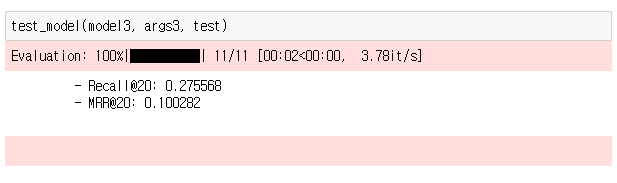

### 2. 알게된 것
- MRR은 처음알게 된 평가지표이다.
- 평균 상호 순위로 이 방법은 계산하기 쉽고 해석하기 쉽다고 한다
- '나에게 가장 적합한 항목'을 묻는 등의 타겟 검색에 가자 적합하다고 한다
- 이외에도 다양한 추천시스템 평가지표를 다음 블로그를 통해 알고 정리할 수 있었다
- https://koreapy.tistory.com/1185

### 3. 회고
- 이번 프로젝트는 사실 너무너무 어려웠다. 프로젝트를 진행하기 위한 사전 내용을 이해하는데 시간이 너무 많이걸렸다. 데이터를 전처리하는 과정부터 막혀서 힘들었는데 이것저것 찾아보고 직접 해보면서 마무리를 겨우 할 수 있었다. 
- SessionDataLoader를 비롯해 모델을 학습시키는 함수들의 코드를 하나하나 이해하고 싶었지만 아직 벅차서 시간을 좀더 투자해서 계속 봐야할 것 같다.
- 매번 느끼지만 판다스를 잘 다룰 줄 알아야겠다..!! 다룰 줄 모르면 아무것도 못할테니..!
- 추천시스템에 관심이 있었는데 생각보다 많이 어려운 분야인것 같다.